In [212]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [205]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='latin1') # Nxd(3072) (Nx (32x32x3))
        X = np.transpose(dataset['data'] / 255.) # d x N
        y = np.array(dataset['labels'])
        Y = np.transpose(np.eye(X.shape[1], np.max(y) + 1)[y]) # K x N
        return X, Y, y

In [206]:
def softmax(s):
    exponent = np.exp(s)
    return np.divide(exponent, np.sum(exponent, axis=0))

def evaluate_classifier(X, W, b):
    bn = np.dot(b, np.ones([1,X.shape[1]]))
    return softmax(np.dot(W, X) + bn)

In [232]:
def compute_cost(X, Y, W, b, lmb):
    p = evaluate_classifier(X, W, b)
    n = np.dot(Y.T, p)
    cross_entropy = np.sum(-np.log(np.diag(n)))
    
    w_square_sum = 0
    if lmb > 0:
        w_square_sum = np.sum(np.diag(np.dot(W.T, W)))
    return (cross_entropy / X.shape[1]) + (lmb * w_square_sum)

def compute_gradients(X, Y, p, W, lmb):
    G = -(Y - p)
    grad_lossW = np.divide(np.dot(G, X.T), X.shape[1])
    grad_W = grad_lossW + (2 * lmb * W)
    grad_b = np.divide(np.dot(G, np.ones((X.shape[1], 1))), X.shape[1])
    return grad_W, grad_b
    
def compute_gradients_num(X, Y, W, b, lmb, h):
    no = W.shape[0]
    d = X.shape[0]
    
    grad_W = np.zeros(W.shape)
    grad_b = np.zeros(no)
    c = compute_cost(X, Y, W, b, lmb)
    
    for i in range(len(b)):
        b_try = np.copy(b)
        b_try[i] = b_try[i] + h
        c2 = compute_cost(X, Y, W, b_try, lmb)
        grad_b[i] = (c2 - c) / h
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.copy(W)
            W_try[i,j] = W_try[i,j] + h
            c2 = compute_cost(X, Y, W_try, b, lmb)
            grad_W[i,j] = (c2 - c) / h
        
    return grad_W, grad_b

In [211]:
def compute_accuracy(X, y, W, b):
    p = evaluate_classifier(X, W, b)
    argmax = np.argmax(p, axis=0) # max element index of each column
    diff = argmax - y
    return (diff == 0).sum() / X.shape[1]

In [209]:
def mini_batch_GD(X, Y, GDparams, W, b, lmb, validation):
    print(GDparams)
    J_training = np.zeros(GDparams["epochs"])
    J_validation = np.zeros(GDparams["epochs"])
    
    runs_in_epoch = int(X.shape[1] / GDparams["n_batch"])
    for epoch in range(GDparams["epochs"]):
        for j in range(1, runs_in_epoch):
            j_start = (j - 1) * GDparams["n_batch"]
            j_end = j * GDparams["n_batch"]
            
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]
            
            p = evaluate_classifier(X_batch, W, b)
            grad_W, grad_b = compute_gradients(X_batch, Y_batch, p, W, lmb)
            
            W = W - (GDparams["eta"] * grad_W)
            b = b - (GDparams["eta"] * grad_b)
        
        J_training[epoch] = compute_cost(X, Y, W, b, lmb)
        J_validation[epoch] = compute_cost(validation["X"], validation["Y"], W, b, lmb)
        print(J_training[epoch])
    return W, b

In [234]:
np.random.seed(0)

X, Y, y = load_batch('data/data_batch_1')
X_valid, Y_valid, y_valid = load_batch('data/data_batch_2')
X_test, Y_test, y_test = load_batch('data/test_batch')

d = X.shape[0]
N = X.shape[1]
K = Y.shape[0]

std_dev = 1 / np.sqrt(d)
W = std_dev * np.random.randn(K, d)
b = std_dev * np.random.randn(K, 1)

lmb = 0.1  # lambda
GDparams = {
    "n_batch": 100,
    "eta": .01,
    "epochs": 40,
}
validation = {
    "X": X_valid,
    "Y": Y_valid,
}

In [233]:
feature_dims = 20
samples = 1

W_g = W[:,0:feature_dims] #K X d
X_g = X[0:feature_dims, 0:samples] #d X N
Y_g = Y[:, 0:samples] #K x N

grad_W, grad_b = compute_gradients(X_g, Y_g, p, W_g, lmb)
ngrad_w, ngrad_b = compute_gradients_num(X_g, Y_g, W_g, b, lmb, 1e-6)
print("\ngrad b:")
print(grad_b)
print(ngrad_b)


grad b:
[[ 0.10862683]
 [ 0.10352576]
 [ 0.10291581]
 [ 0.09188528]
 [ 0.09759392]
 [ 0.10078407]
 [-0.89749406]
 [ 0.09730564]
 [ 0.09485048]
 [ 0.10000626]]
[ 0.10862688  0.1035258   0.10291586  0.09188533  0.09759397  0.10078411
 -0.89749401  0.09730568  0.09485053  0.10000631]


In [223]:
W_star, b_star = mini_batch_GD(X, Y, GDparams, W, b, lmb, validation)
test_cost = compute_cost(X_test, Y_test, W_star, b_star, lmb)
test_acc = compute_accuracy(X_test, y_test, W_star, b_star)

print("\nTest cost: {}".format(test_cost))
print("Test accuracy: {}".format(test_acc))

{'n_batch': 100, 'eta': 0.01, 'epochs': 40}
2.722545228525637
2.4575442485245733
2.294393535213346
2.188864668819199
2.1193823206269236
2.0732491813279283
2.0424745706649747
2.0218798292542424
2.008060777713339
1.998762968155579
1.9924870305526654
1.9882331732708471
1.98533358390954
1.9833416651008011
1.9819584989520322
1.9809838840325933
1.9802836685853613
1.979767925115985
1.9793763530666015
1.9790685080665487
1.9788172578772019
1.9786043973641487
1.9784177090881505
1.9782489923543511
1.9780927413310347
1.9779452583268693
1.9778040588915864
1.9776674726593824
1.9775343755103554
1.9774040098408803


KeyboardInterrupt: 

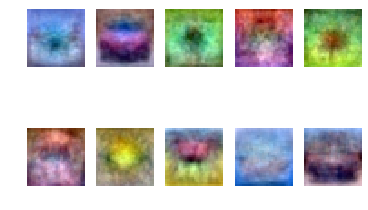

In [222]:
plt.figure(1)
for i, j in enumerate(W_star):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.rot90(np.reshape((j - j.min()) / (j.max() - j.min()), (32, 32, 3), order='F'), k=3))
    plt.axis("off")
plt.show()